In [1]:
!pip install yellowbrick
!pip uninstall tensorflow tensorflow-metal tensorflow-macos -y
!pip install scikeras scikit-learn tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.utils.multiclass import type_of_target
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.decomposition import PCA
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold

Found existing installation: tensorflow 2.16.2
Uninstalling tensorflow-2.16.2:
  Successfully uninstalled tensorflow-2.16.2
  Using cached tensorflow-2.16.2-cp311-cp311-macosx_10_15_x86_64.whl.metadata (4.1 kB)
Using cached tensorflow-2.16.2-cp311-cp311-macosx_10_15_x86_64.whl (259.6 MB)


2025-02-27 19:22:42.012276: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('./salary.csv', low_memory=False)

df['EMPLOY DATE'] = pd.to_datetime(df['EMPLOY DATE'], format='mixed', errors='coerce')

df['Year'] = df['EMPLOY DATE'].dt.year

df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Exploratory Data Analysis

In [3]:
df.head()

,AGENCY,AGENCY NAME,LAST NAME,FIRST NAME,MI,CLASS CODE,CLASS TITLE,ETHNICITY,GENDER,STATUS,...,HRS PER WK,MONTHLY,ANNUAL,STATE NUMBER,duplicated,multiple_full_time_jobs,combined_multiple_jobs,summed_annual_salary,hide_from_search,Year
0,241,"COMPTROLLER OF PUBLIC ACCOUNTS, JUDICIARY SECT...",RUCKER,MORTON,V,JD25,"JUDGE, RETIRED ...",WHITE,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,...,29.0,9545.82,114549.84,127717,True,NaN,NaN,131407.08,NaN,1988
1,212,OFFICE OF COURT ADMINISTRATION ...,RUCKER,MORTON,V,3524,GENERAL COUNSEL IV ...,WHITE,MALE,CTP - CLASSIFIED TEMPORARY PART-TIME,...,4.0,1404.77,16857.24,127717,True,NaN,NaN,NaN,True,2015
2,241,"COMPTROLLER OF PUBLIC ACCOUNTS, JUDICIARY SECT...",SPECIA JR,JOHN,J,JD25,"JUDGE, RETIRED ...",WHITE,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,...,29.0,9545.82,114549.84,59115,True,NaN,NaN,131407.08,NaN,2020
3,212,OFFICE OF COURT ADMINISTRATION ...,SPECIA JR,JOHN,J,3524,GENERAL COUNSEL IV ...,WHITE,MALE,CTP - CLASSIFIED TEMPORARY PART-TIME,...,4.0,1404.77,16857.24,59115,True,NaN,NaN,NaN,True,2018
4,696,TEXAS DEPARTMENT OF CRIMINAL JUSTICE ...,ONTIVEROS,ESTHER,,4504,CORREC OFFICER IV ...,HISPANIC,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,3284.27,39411.24,165030,True,1.0,NaN,NaN,NaN,2020


In [4]:
df.tail()

,AGENCY,AGENCY NAME,LAST NAME,FIRST NAME,MI,CLASS CODE,CLASS TITLE,ETHNICITY,GENDER,STATUS,...,HRS PER WK,MONTHLY,ANNUAL,STATE NUMBER,duplicated,multiple_full_time_jobs,combined_multiple_jobs,summed_annual_salary,hide_from_search,Year
149476,809,STATE PRESERVATION BOARD ...,WESSELS,JOHN,P,6232,SECURITY OFFICER III ...,WHITE,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,2899.00,34788.00,770781,NaN,NaN,NaN,NaN,NaN,2017
149477,809,STATE PRESERVATION BOARD ...,WINDHAM,EVAN,A,0302,WEB ADMINISTRATOR III ...,WHITE,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,5500.00,66000.00,847431,NaN,NaN,NaN,NaN,NaN,2015
149478,809,STATE PRESERVATION BOARD ...,WRIGHT,DERRICK,C,0130,CUSTOMER SERVICE REP I ...,WHITE,MALE,CRP - CLASSIFIED REGULAR PART-TIME,...,20.0,1120.60,13447.20,34266,NaN,NaN,NaN,NaN,NaN,2012
149479,809,STATE PRESERVATION BOARD ...,YOUNG,DOUGLAS,R,1572,PROGRAM SPECIALIST III ...,WHITE,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,5744.16,68929.92,123490,NaN,NaN,NaN,NaN,NaN,1989
149480,809,STATE PRESERVATION BOARD ...,ZUNKER,GEORGIA,P,0130,CUSTOMER SERVICE REP I ...,WHITE,FEMALE,CRP - CLASSIFIED REGULAR PART-TIME,...,20.0,1017.46,12209.52,103583,NaN,NaN,NaN,NaN,NaN,2012


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149481 entries, 0 to 149480
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   AGENCY                   149481 non-null  int64         
 1   AGENCY NAME              149481 non-null  object        
 2   LAST NAME                149481 non-null  object        
 3   FIRST NAME               149481 non-null  object        
 4   MI                       149481 non-null  object        
 5   CLASS CODE               149481 non-null  object        
 6   CLASS TITLE              149481 non-null  object        
 7   ETHNICITY                149481 non-null  object        
 8   GENDER                   149481 non-null  object        
 9   STATUS                   149481 non-null  object        
 10  EMPLOY DATE              149481 non-null  datetime64[ns]
 11  HRLY RATE                149481 non-null  float64       
 12  HRS PER WK      

In [6]:
df.isnull().sum()

AGENCY                          0
AGENCY NAME                     0
LAST NAME                       0
FIRST NAME                      0
MI                              0
CLASS CODE                      0
CLASS TITLE                     0
ETHNICITY                       0
GENDER                          0
STATUS                          0
EMPLOY DATE                     0
HRLY RATE                       0
HRS PER WK                      0
MONTHLY                         0
ANNUAL                          0
STATE NUMBER                    0
duplicated                 149338
multiple_full_time_jobs    149467
combined_multiple_jobs     149384
summed_annual_salary       149465
hide_from_search           149465
Year                            0
dtype: int64

In [7]:
df.isna().sum()

AGENCY                          0
AGENCY NAME                     0
LAST NAME                       0
FIRST NAME                      0
MI                              0
CLASS CODE                      0
CLASS TITLE                     0
ETHNICITY                       0
GENDER                          0
STATUS                          0
EMPLOY DATE                     0
HRLY RATE                       0
HRS PER WK                      0
MONTHLY                         0
ANNUAL                          0
STATE NUMBER                    0
duplicated                 149338
multiple_full_time_jobs    149467
combined_multiple_jobs     149384
summed_annual_salary       149465
hide_from_search           149465
Year                            0
dtype: int64

In [8]:
df.describe()

,AGENCY,EMPLOY DATE,HRLY RATE,HRS PER WK,MONTHLY,ANNUAL,STATE NUMBER,multiple_full_time_jobs,summed_annual_salary,Year
count,149481.000000,149481,149481.000000,149481.000000,149481.000000,149481.000000,1.494810e+05,14.0,16.000000,149481.000000
mean,545.736288,2014-01-13 19:01:23.159732480,0.346488,39.714918,4226.184248,50714.210973,5.651930e+05,1.0,74303.955000,2013.544109
min,101.000000,1975-09-01 00:00:00,0.000000,1.000000,50.000000,600.000000,1.000000e+00,1.0,18000.000000,1975.000000
25%,529.000000,2010-12-20 00:00:00,0.000000,40.000000,3019.840000,36238.080000,1.133340e+05,1.0,32962.500000,2010.000000
50%,530.000000,2016-10-10 00:00:00,0.000000,40.000000,3720.170000,44642.040000,3.463730e+05,1.0,48063.300000,2016.000000
75%,696.000000,2018-12-03 00:00:00,0.000000,40.000000,4865.810000,58389.720000,1.100500e+06,1.0,123751.770000,2018.000000
max,930.000000,2073-09-10 00:00:00,117.788480,70.000000,46125.000000,553500.000000,1.271604e+06,1.0,171383.400000,2073.000000
std,139.057691,NaN,4.211485,2.323855,2093.111691,25117.340292,4.786212e+05,0.0,51925.944282,6.803192


In [9]:
df['AGENCY'].value_counts()

AGENCY
529    36667
696    35926
601    13099
530    12588
405    10097
       ...  
364        7
481        5
213        4
464        4
510        1
Name: count, Length: 113, dtype: int64

In [10]:
df['AGENCY NAME'].value_counts()

AGENCY NAME
HEALTH AND HUMAN SERVICES COMMISSION                  36667
TEXAS DEPARTMENT OF CRIMINAL JUSTICE                  35926
TEXAS DEPARTMENT OF TRANSPORTATION                    13099
DEPARTMENT OF FAMILY AND PROTECTIVE SERVICES          12588
DEPARTMENT OF PUBLIC SAFETY                           10097
                                                      ...  
HEALTH PROFESSIONS COUNCIL                                7
BOARD OF PROFESSIONAL GEOSCIENTISTS                       5
OFFICE OF STATE PROSECUTING ATTORNEY                      4
BOARD OF PROFESSIONAL LAND SURVEYING                      4
TEXAS BEHAVIORAL HEALTH EXECUTIVE COUNCIL                 1
Name: count, Length: 113, dtype: int64

In [11]:
df['CLASS CODE'].value_counts()

CLASS CODE
4504        9267
4505        7895
4503        4718
5622        3646
5121        3307
            ... 
U101           1
U104           1
E176           1
U103           1
E096           1
Name: count, Length: 1481, dtype: int64

In [12]:
df['CLASS TITLE'].value_counts()

CLASS TITLE
CORREC  OFFICER IV                                    9267
CORREC  OFFICER V                                     7895
CORREC OFFCR III                                      4718
TEXAS WORKS ADVISOR II                                3646
DIRECT SUPPORT PROFESSIONAL I                         3307
                                                      ... 
CHAIR,PARDONS AND PAROLES                                1
STATISTICIAN II                                          1
EX DIRECTOR TDCJ                                         1
PAYROLL SPECIALIST I                                     1
DEPUTY DIR/APPS MGR                                      1
Name: count, Length: 1422, dtype: int64

In [13]:
df['ETHNICITY'].value_counts()

ETHNICITY
WHITE              67142
HISPANIC           40585
BLACK              35853
ASIAN               4268
OTHER                921
AM INDIAN            712
Name: count, dtype: int64

In [14]:
df['GENDER'].value_counts()

GENDER
FEMALE             85328
MALE               64153
Name: count, dtype: int64

In [15]:
df['STATUS'].value_counts()

STATUS
CRF - CLASSIFIED REGULAR FULL-TIME          142502
URF - UNCLASSIFIED REGULAR FULL-TIME          2363
CRP - CLASSIFIED REGULAR PART-TIME            1531
CTF - CLASSIFIED TEMPORARY FULL-TIME          1096
URP - UNCLASSIFIED REGULAR PART-TIME           950
ERF - EXEMPT REGULAR FULL-TIME                 923
CTP - CLASSIFIED TEMPORARY PART-TIME            81
UTP - UNCLASSIFIED TEMPORARY PART-TIME          21
UTF - UNCLASSIFIED TEMPORARY FULL-TIME          12
ERP - EXEMPT REGULAR PART-TIME                   1
CTP - CLASSIFIED TEMPORARY FULL-TIME             1
Name: count, dtype: int64

In [16]:
df['STATE NUMBER'].value_counts()

STATE NUMBER
127717     2
1049439    2
193187     2
949488     2
97642      2
          ..
124412     1
1129493    1
20632      1
1197251    1
103583     1
Name: count, Length: 149465, dtype: int64

In [17]:
df[df.duplicated(subset=['STATE NUMBER'], keep=False)]

,AGENCY,AGENCY NAME,LAST NAME,FIRST NAME,MI,CLASS CODE,CLASS TITLE,ETHNICITY,GENDER,STATUS,...,HRS PER WK,MONTHLY,ANNUAL,STATE NUMBER,duplicated,multiple_full_time_jobs,combined_multiple_jobs,summed_annual_salary,hide_from_search,Year
0,241,"COMPTROLLER OF PUBLIC ACCOUNTS, JUDICIARY SECT...",RUCKER,MORTON,V,JD25,"JUDGE, RETIRED ...",WHITE,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,...,29.0,9545.82,114549.84,127717,True,NaN,NaN,131407.08,NaN,1988
1,212,OFFICE OF COURT ADMINISTRATION ...,RUCKER,MORTON,V,3524,GENERAL COUNSEL IV ...,WHITE,MALE,CTP - CLASSIFIED TEMPORARY PART-TIME,...,4.0,1404.77,16857.24,127717,True,NaN,NaN,NaN,True,2015
2,241,"COMPTROLLER OF PUBLIC ACCOUNTS, JUDICIARY SECT...",SPECIA JR,JOHN,J,JD25,"JUDGE, RETIRED ...",WHITE,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,...,29.0,9545.82,114549.84,59115,True,NaN,NaN,131407.08,NaN,2020
3,212,OFFICE OF COURT ADMINISTRATION ...,SPECIA JR,JOHN,J,3524,GENERAL COUNSEL IV ...,WHITE,MALE,CTP - CLASSIFIED TEMPORARY PART-TIME,...,4.0,1404.77,16857.24,59115,True,NaN,NaN,NaN,True,2018
7,510,TEXAS BEHAVIORAL HEALTH EXECUTIVE COUNCIL ...,SPINKS,DARREL,D,1623,DIRECTOR IV ...,WHITE,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,10000.00,120000.00,147334,True,NaN,NaN,171383.40,NaN,2020
8,520,BOARD OF EXAMINERS OF PSYCHOLOGISTS ...,SPINKS,DARREL,D,E178,"EXEC DIR, BD OF EXAMS OF PSYCHOLOGISTS ...",WHITE,MALE,ERP - EXEMPT REGULAR PART-TIME,...,20.0,4281.95,51383.40,147334,True,NaN,NaN,NaN,True,2020
20,771,SCHOOL FOR THE BLIND AND VISUALLY IMPAIRED ...,GRANGER,EVELYN,F,9323,VEHICLE DRIVER II ...,HISPANIC,FEMALE,CRP - CLASSIFIED REGULAR PART-TIME,...,20.0,1375.00,16500.00,1049439,True,NaN,NaN,31950.00,NaN,2016
21,771,SCHOOL FOR THE BLIND AND VISUALLY IMPAIRED ...,GRANGER,EVELYN,F,5203,RESIDENT SPECIALIST II ...,HISPANIC,FEMALE,CRP - CLASSIFIED REGULAR PART-TIME,...,20.0,1287.50,15450.00,1049439,True,NaN,NaN,NaN,True,2016
22,771,SCHOOL FOR THE BLIND AND VISUALLY IMPAIRED ...,KICKERTZ,ANDREW,D,5205,RESIDENT SPECIALIST III ...,WHITE,MALE,CRP - CLASSIFIED REGULAR PART-TIME,...,20.0,1500.00,18000.00,1219460,True,NaN,NaN,33300.00,NaN,2019
23,771,SCHOOL FOR THE BLIND AND VISUALLY IMPAIRED ...,KICKERTZ,ANDREW,D,5203,RESIDENT SPECIALIST II ...,WHITE,MALE,CRP - CLASSIFIED REGULAR PART-TIME,...,20.0,1275.00,15300.00,1219460,True,NaN,NaN,NaN,True,2019


In [18]:
df[df['multiple_full_time_jobs'].notna()]

,AGENCY,AGENCY NAME,LAST NAME,FIRST NAME,MI,CLASS CODE,CLASS TITLE,ETHNICITY,GENDER,STATUS,...,HRS PER WK,MONTHLY,ANNUAL,STATE NUMBER,duplicated,multiple_full_time_jobs,combined_multiple_jobs,summed_annual_salary,hide_from_search,Year
4,696,TEXAS DEPARTMENT OF CRIMINAL JUSTICE ...,ONTIVEROS,ESTHER,,4504,CORREC OFFICER IV ...,HISPANIC,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,3284.27,39411.24,165030,True,1.0,NaN,NaN,NaN,2020
5,302,OFFICE OF THE ATTORNEY GENERAL ...,ROGERS,SHAUNA,,1623,DIRECTOR IV ...,HISPANIC,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,12899.00,154788.00,1177785,True,1.0,NaN,NaN,NaN,2020
6,601,TEXAS DEPARTMENT OF TRANSPORTATION ...,RICHTER,WILLIAM,J,1984,CONTRACT SPEC IV ...,WHITE,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,5835.50,70026.00,1085586,True,1.0,NaN,NaN,NaN,2020
9,537,DEPARTMENT OF STATE HEALTH SERVICES ...,ADAMS III,LEE,A,1323,INSPECTOR III ...,BLACK,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,3447.25,41367.00,129635,True,1.0,NaN,NaN,NaN,2019
10,530,DEPARTMENT OF FAMILY AND PROTECTIVE SERVICES ...,ALONZO,LUIS,C,5023,CHILD PROTECTIVE SVCS SPEC I ...,HISPANIC,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,3816.65,45799.80,1055383,True,1.0,NaN,NaN,NaN,2020
11,529,HEALTH AND HUMAN SERVICES COMMISSION ...,HARVEST,SHEILA,,1322,INSPECTOR II ...,BLACK,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,2514.58,30174.96,1196278,True,1.0,NaN,NaN,NaN,2020
12,537,DEPARTMENT OF STATE HEALTH SERVICES ...,LAGRONE,ADEENA,,1014,ACCOUNTANT II ...,WHITE,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,3120.83,37449.96,1241034,True,1.0,NaN,NaN,NaN,2020
13,537,DEPARTMENT OF STATE HEALTH SERVICES ...,LOPEZ,VANESSA,C,1984,CONTRACT SPEC IV ...,HISPANIC,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,4506.84,54082.08,746323,True,1.0,NaN,NaN,NaN,2020
14,551,DEPARTMENT OF AGRICULTURE ...,MOTEN,ROBIN,M,0154,ADMINISTRATIVE ASST III ...,BLACK,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,3150.00,37800.00,31804,True,1.0,NaN,NaN,NaN,2020
15,530,DEPARTMENT OF FAMILY AND PROTECTIVE SERVICES ...,PALOMBO,KAREN,,1574,PROGRAM SPECIALIST V ...,WHITE,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,5954.55,71454.60,37046,True,1.0,NaN,NaN,NaN,2020


In [19]:
df[df['combined_multiple_jobs'].notna()].sort_values(by=["STATE NUMBER"])

,AGENCY,AGENCY NAME,LAST NAME,FIRST NAME,MI,CLASS CODE,CLASS TITLE,ETHNICITY,GENDER,STATUS,...,HRS PER WK,MONTHLY,ANNUAL,STATE NUMBER,duplicated,multiple_full_time_jobs,combined_multiple_jobs,summed_annual_salary,hide_from_search,Year
116,303,TEXAS FACILITIES COMMISSION ...,HUNTER,BRIDGET,C,0150,ADMINISTRATIVE ASST I ...,BLACK,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,2700.00,32400.00,704,True,NaN,True,NaN,NaN,2020
66,101,SENATE ...,SANCHEZ,LUIS,M,7101,LEG. OFFICIAL/ADMINISTRATOR ...,HISPANIC,MALE,URF - UNCLASSIFIED REGULAR FULL-TIME,...,40.0,10500.00,126000.00,11355,True,NaN,True,NaN,NaN,2007
98,102,HOUSE OF REPRESENTATIVES ...,SHUFELT,BRYAN,K,7110,ELECTED OFFICIALS STAFF ...,WHITE,MALE,URF - UNCLASSIFIED REGULAR FULL-TIME,...,50.0,6560.00,78720.00,24928,True,NaN,True,NaN,NaN,2014
129,303,TEXAS FACILITIES COMMISSION ...,SIM,MEGAN,C,1600,MGR I ...,WHITE,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,5833.34,70000.08,25352,True,NaN,True,NaN,NaN,2005
53,101,SENATE ...,KENNY,PAT,,7104,LEGISLATIVE PROFESSIONAL ...,WHITE,FEMALE,URF - UNCLASSIFIED REGULAR FULL-TIME,...,41.0,4140.18,49682.16,37375,True,NaN,True,NaN,NaN,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,303,TEXAS FACILITIES COMMISSION ...,STEGER,JAYNE,E,2741,RISK MGMT SPEC II ...,WHITE,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,3233.34,38800.08,1246133,True,NaN,True,NaN,NaN,2019
119,303,TEXAS FACILITIES COMMISSION ...,LACOMBE,JAMES,C,1602,MGR III ...,WHITE,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,6500.00,78000.00,1247661,True,NaN,True,NaN,NaN,2020
134,303,TEXAS FACILITIES COMMISSION ...,STRONG,ELIZABETH,A,1823,MARKETING SPECIALIST II ...,OTHER,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,4200.00,50400.00,1252481,True,NaN,True,NaN,NaN,2020
118,303,TEXAS FACILITIES COMMISSION ...,JONES,JESSE,F,1914,INVENTORY & STORE SPEC IV ...,OTHER,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,...,40.0,3240.00,38880.00,1252581,True,NaN,True,NaN,NaN,2020


In [20]:
df[df['multiple_full_time_jobs'].notna() & df.duplicated(subset=['STATE NUMBER'], keep=False)]

,AGENCY,AGENCY NAME,LAST NAME,FIRST NAME,MI,CLASS CODE,CLASS TITLE,ETHNICITY,GENDER,STATUS,...,HRS PER WK,MONTHLY,ANNUAL,STATE NUMBER,duplicated,multiple_full_time_jobs,combined_multiple_jobs,summed_annual_salary,hide_from_search,Year


In [21]:
numeric_columns = df.select_dtypes(include=['int64', 'int32', 'float64']).columns

<Axes: >

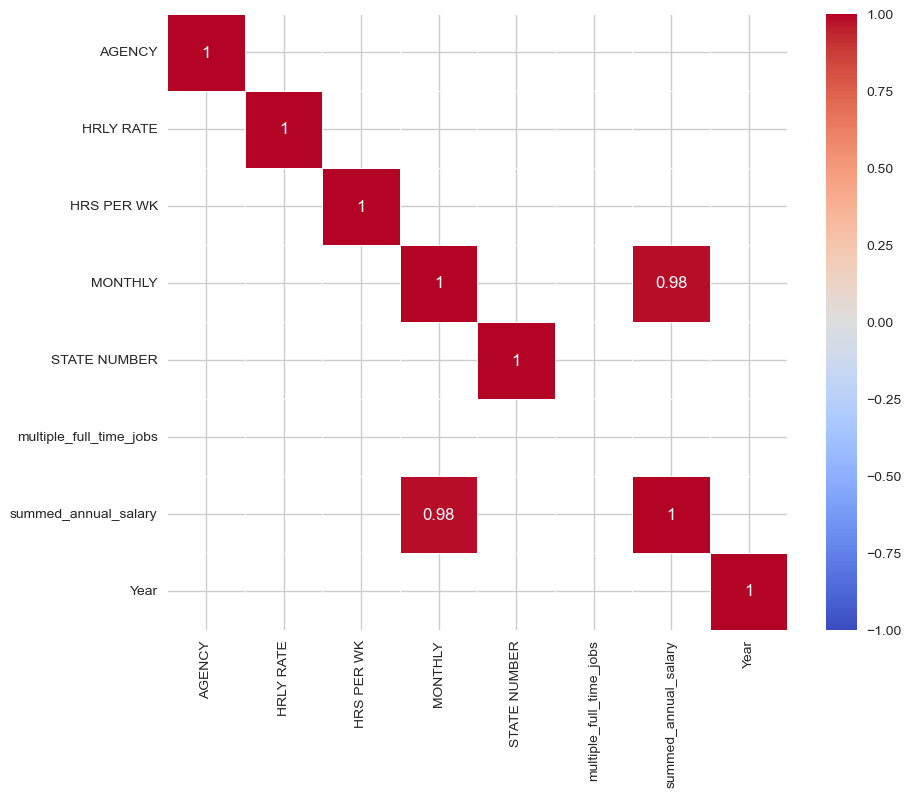

In [22]:
df_corr = df[numeric_columns].drop("ANNUAL", axis=1).corr()
masked = (df_corr.abs() < 0.8)
df_corr_masked = df_corr.mask(masked)
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr_masked, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5, mask=masked)

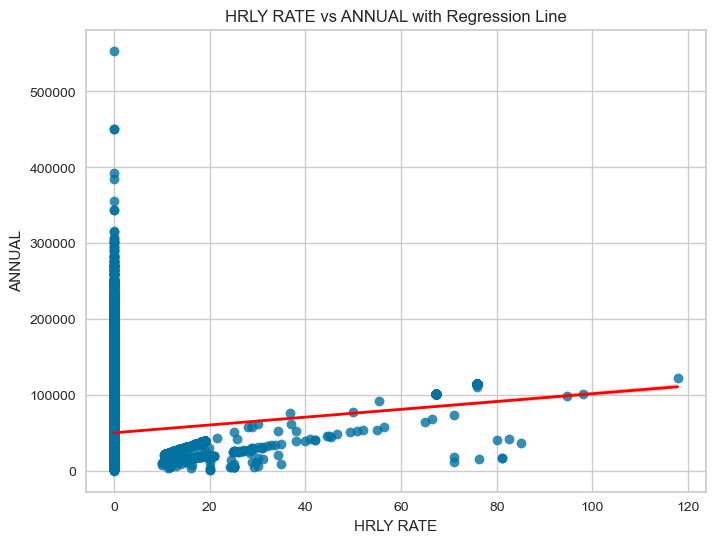

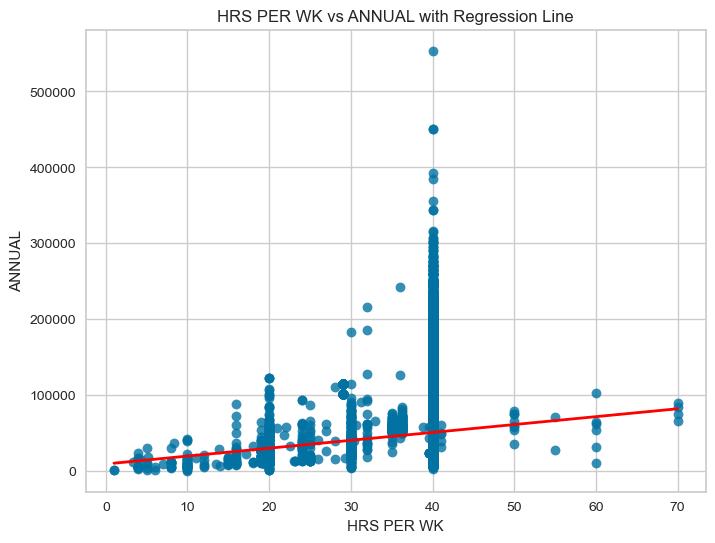

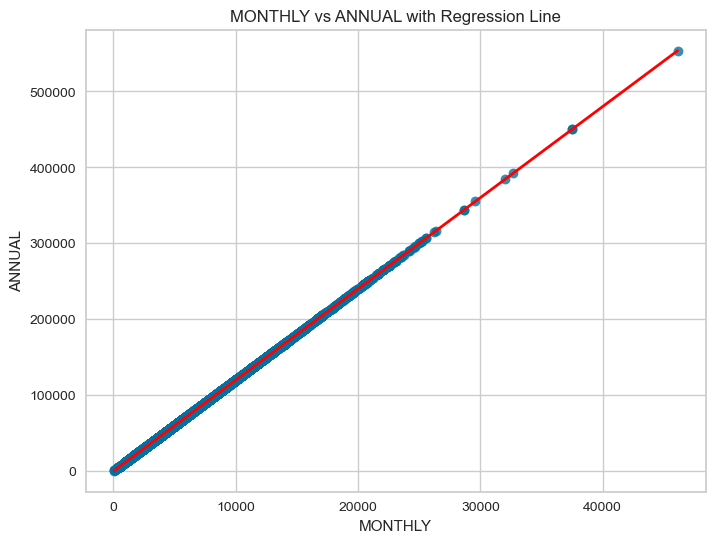

In [23]:
contineous_features = ["HRLY RATE", "HRS PER WK", "MONTHLY"]
for feature in contineous_features:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=feature, y='ANNUAL', data=df, scatter_kws={'s': 50}, line_kws={'color': 'red', 'lw': 2})
    plt.title(f'{feature} vs ANNUAL with Regression Line')
    plt.xlabel(feature)
    plt.ylabel('ANNUAL')
    plt.show()

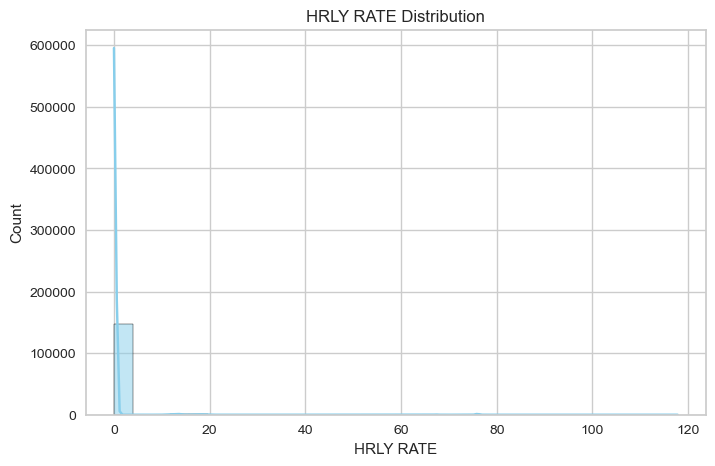

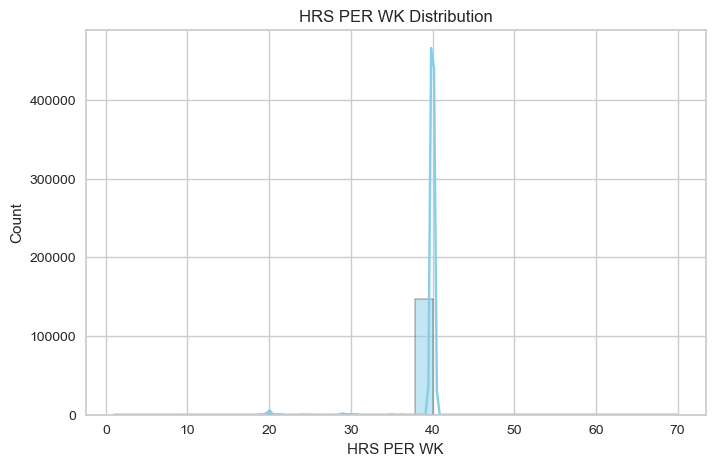

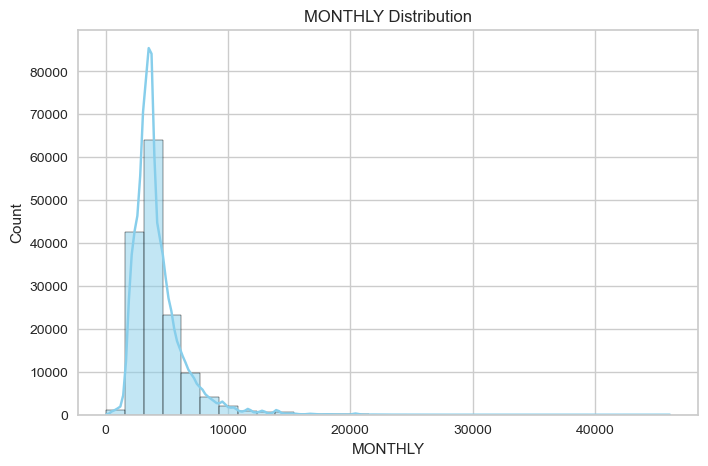

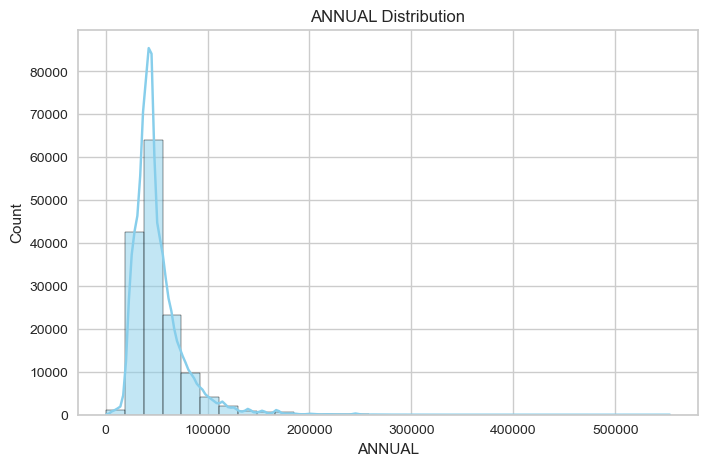

In [24]:
contineous_features = ["HRLY RATE", "HRS PER WK", "MONTHLY", "ANNUAL"]
for feature in contineous_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], bins=30, kde=True, color='skyblue')
    plt.title(f'{feature} Distribution')
    plt.show()

## Identify salary outliers

In [25]:
def identify_salary_outliers(df):
    # Aggregate annual salaries per employee
    employee_df = df.groupby('STATE NUMBER').agg({
        'ANNUAL': 'last',
        'AGENCY NAME': 'last',
        'CLASS TITLE': 'last'
    }).reset_index()
    
    # IQR-based outlier detection
    Q1 = employee_df['ANNUAL'].quantile(0.25)
    Q3 = employee_df['ANNUAL'].quantile(0.75)
    IQR = Q3 - Q1
    bounds = [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    
    outliers = employee_df[
        (employee_df['ANNUAL'] < bounds[0]) | 
        (employee_df['ANNUAL'] > bounds[1])
    ].sort_values('ANNUAL', ascending=False)
    
    return outliers

salary_outliers = identify_salary_outliers(df)
print(f"Found {len(salary_outliers)} salary outliers:")
salary_outliers[['STATE NUMBER', 'AGENCY NAME', 'CLASS TITLE', 'ANNUAL']]

Found 9027 salary outliers:


,STATE NUMBER,AGENCY NAME,CLASS TITLE,ANNUAL
78692,372291,CANCER PREVENTION AND RESEARCH INSTITUTE OF TE...,CHIEF SCIENTIFIC OFFICER ...,553500.00
40022,121522,TEACHER RETIREMENT SYSTEM ...,CHIEF INVESTMENT OFFICER ...,450000.00
8084,24680,EMPLOYEES RETIREMENT SYSTEM ...,DIRECTOR OF INVESTMENTS ...,450000.00
41024,124553,TEACHER RETIREMENT SYSTEM ...,SENIOR MANAGING DIRECTOR ...,391999.92
2547,7792,TEXAS EDUCATION AGENCY ...,PSF CHIEF INVESTMENT OFFICER ...,384375.00
...,...,...,...,...
95124,931560,HOUSE OF REPRESENTATIVES ...,ELECTED OFFICIALS STAFF ...,1200.00
38996,118315,HOUSE OF REPRESENTATIVES ...,ELECTED OFFICIALS STAFF ...,1200.00
57794,176291,SENATE ...,LEG. SERVICE/MAINTENANCE ...,1039.92
139622,1246122,SENATE ...,LEG. SERVICE/MAINTENANCE ...,1039.92


## Departments/roles have the biggest wage disparities between managers and employees

In [26]:
manager_keywords = ['Manager', 'Director', 'Supervisor', 'Chief', 'Head', 'Lead', 'Mgr', 'Dir', 'Supv', 'Supr']

# Flag managerial roles
df['Is_Manager'] = df['CLASS TITLE'].str.contains(
    '|'.join(manager_keywords), 
    case=False, 
    na=False
)
agency_disparity = df.groupby('AGENCY NAME').apply(
    lambda x: pd.Series({
        'Manager_Avg_Salary': x[x['Is_Manager']]['ANNUAL'].mean(),
        'NonManager_Avg_Salary': x[~x['Is_Manager']]['ANNUAL'].mean(),
        'Disparity_Ratio': x[x['Is_Manager']]['ANNUAL'].mean() / x[~x['Is_Manager']]['ANNUAL'].mean(),
        'Employee_Count': len(x)
    })
).reset_index()

# Filter agencies with sufficient data
agency_disparity = agency_disparity[
    (agency_disparity['Employee_Count'] > 10) & 
    (~agency_disparity['Disparity_Ratio'].isna())
].sort_values('Disparity_Ratio', ascending=False)

print("Departments with Largest Wage Gaps (Managers vs. Employees):")
print(agency_disparity[['AGENCY NAME', 'Disparity_Ratio']].head(10))


Departments with Largest Wage Gaps (Managers vs. Employees):
                                           AGENCY NAME  Disparity_Ratio
12   CANCER PREVENTION AND RESEARCH INSTITUTE OF TE...         2.842587
44   LEGISLATIVE REFERENCE LIBRARY                 ...         2.656515
76   STATE PRESERVATION BOARD                      ...         2.497147
47   OFFICE OF CAPITAL AND FORENSIC WRITS          ...         2.412002
61   SAVINGS AND LOAN DEPARTMENT                   ...         2.223105
79   TEACHER RETIREMENT SYSTEM                     ...         2.139846
101  TEXAS LOTTERY COMMISSION                      ...         2.086736
7    BOARD OF PLUMBING EXAMINERS                   ...         2.045962
66   SECURITIES BOARD                              ...         2.035918
108  THIRD COURT OF APPEALS DISTRICT               ...         2.027896


## salaries and total compensations for some roles/ departments/ head-count changed over time?

In [27]:
grouped = df.groupby(['Year', 'AGENCY NAME']).agg(
    Avg_Salary=('ANNUAL', 'mean'),
    Total_Compensation=('ANNUAL', 'sum'),
    Headcount=('STATE NUMBER', 'nunique')
).reset_index()

salary_pivot = grouped.pivot_table(
    index=['AGENCY NAME'],
    columns='Year',
    values='Avg_Salary'
)

# Calculate the 5-year percent change across years
pct_change_df = salary_pivot.pct_change(axis='columns', periods=5, fill_method=None)

# Compute the mean of the last 5 columns (you might be averaging across several available periods)
salary_growth = pct_change_df.iloc[:, -5:].mean(axis=1)

# Drop rows where the computed 5-year growth is NaN (i.e. insufficient data)
salary_growth = salary_growth.dropna()

# Select the top 5 growing roles based on the 5-year growth rate
top_growing_roles = salary_growth.nlargest(5).reset_index(name='5Yr_Growth')
top_growing_roles


,AGENCY NAME,5Yr_Growth
0,SOIL AND WATER CONSERVATION BOARD ...,1.098042
1,DEPARTMENT OF PUBLIC SAFETY ...,0.742542
2,TEXAS DEPARTMENT OF TRANSPORTATION ...,0.247368
3,TEXAS DEPARTMENT OF CRIMINAL JUSTICE ...,0.204382
4,HOUSE OF REPRESENTATIVES ...,-0.754440


# Preprocessing

## Remove columns with a lot of null values

In [28]:
df.drop(['duplicated', 'multiple_full_time_jobs', 'combined_multiple_jobs', 'summed_annual_salary', 'hide_from_search'], axis=1, inplace=True)

## Remove Data Leakage with Target

In [29]:
df.drop(['MONTHLY', 'HRLY RATE', 'HRS PER WK'], axis=1, inplace=True)

## Feature Engineering

In [30]:
df_sorted = df.sort_values(by=['STATE NUMBER', 'EMPLOY DATE'])

def aggregate_employee(grp):
    # Use the last record as the base for non-aggregated columns
    record = grp.iloc[-1].copy()
    
    # For Start_Date, use the earliest date
    record['start_year'] = grp['EMPLOY DATE'].min().year

    start_salary = grp.iloc[0]['ANNUAL']

    
    # Compute tenure (in years) from the earliest start date to today

    record['tenure'] = (pd.Timestamp.today() - grp['EMPLOY DATE'].min()).days / 365.25 if grp['EMPLOY DATE'].min() <= pd.Timestamp.today() else 0


    
    # Set current_salary to the latest ANNUAL salary (from the last record)
    record['current_salary'] = record['ANNUAL']
    record['salary_growth'] = (record['current_salary'] - start_salary) / start_salary
    record['promotions'] = len(grp) - 1  # Exclude initial record
    return record


df = df_sorted.groupby('STATE NUMBER').apply(aggregate_employee).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149465 entries, 0 to 149464
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   AGENCY          149465 non-null  int64         
 1   AGENCY NAME     149465 non-null  object        
 2   LAST NAME       149465 non-null  object        
 3   FIRST NAME      149465 non-null  object        
 4   MI              149465 non-null  object        
 5   CLASS CODE      149465 non-null  object        
 6   CLASS TITLE     149465 non-null  object        
 7   ETHNICITY       149465 non-null  object        
 8   GENDER          149465 non-null  object        
 9   STATUS          149465 non-null  object        
 10  EMPLOY DATE     149465 non-null  datetime64[ns]
 11  ANNUAL          149465 non-null  float64       
 12  STATE NUMBER    149465 non-null  int64         
 13  Year            149465 non-null  int32         
 14  Is_Manager      149465 non-null  boo

## Remove columns that doesn't add value

In [31]:
df.drop(['MI', "LAST NAME", "FIRST NAME", "STATE NUMBER", 'ANNUAL', 'Year', 'EMPLOY DATE'], axis=1, inplace=True)

## Remove string columns that already has numeric representations

In [32]:
df.drop(["AGENCY", "CLASS TITLE", "CLASS CODE"], axis=1, inplace=True)

## Replace "AM INDIAN" with "ASIAN" in Ethnicity

In [33]:
df['ETHNICITY'] = df['ETHNICITY'].str.strip().str.upper()
df['ETHNICITY'] = df['ETHNICITY'].replace('AM INDIAN', 'ASIAN')

## Replace "STATUS_CTP - CLASSIFIED TEMPORARY FULL-TIME" with "STATUS_CTF - CLASSIFIED TEMPORARY FULL-TIME" as they are no difference

In [34]:
df['STATUS'] = df['STATUS'].str.strip().str.upper()
df['STATUS'] = df['STATUS'].replace('CTP - CLASSIFIED TEMPORARY FULL-TIME', 'CTF - CLASSIFIED TEMPORARY FULL-TIME')

## Encoding

In [35]:
status_mapping = {
    "CRF - CLASSIFIED REGULAR FULL-TIME": 1,
    "URF - UNCLASSIFIED REGULAR FULL-TIME": 1,
    "ERF - EXEMPT REGULAR FULL-TIME": 1,
    "CRP - CLASSIFIED REGULAR PART-TIME": 2,
    "URP - UNCLASSIFIED REGULAR PART-TIME": 2,
    "ERP - EXEMPT REGULAR PART-TIME": 2,
    "CTF - CLASSIFIED TEMPORARY FULL-TIME": 3,
    "UTF - UNCLASSIFIED TEMPORARY FULL-TIME": 3,
    "CTP - CLASSIFIED TEMPORARY FULL-TIME": 3,
    "CTP - CLASSIFIED TEMPORARY PART-TIME": 4,
    "UTP - UNCLASSIFIED TEMPORARY PART-TIME": 4
}

df['GENDER'] = df['GENDER'].str.strip().str.upper()
df = pd.get_dummies(df, columns=['ETHNICITY', 'GENDER', 'AGENCY NAME'], drop_first=True)

df['STATUS'] = df['STATUS'].map(status_mapping)

In [36]:
X = df.drop("current_salary", axis=1)
Y  = df["current_salary"]


bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

# Optionally, ensure the rest of your data is numeric
X = X.apply(pd.to_numeric, errors='raise')

# Add a constant term for the intercept
x = sm.add_constant(X)

# Fit the OLS model
est = sm.OLS(Y, x).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:         current_salary   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     821.3
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:38:36   Log-Likelihood:            -1.6880e+06
No. Observations:              149465   AIC:                         3.376e+06
Df Residuals:                  149342   BIC:                         3.377e+06
Df Model:                         122                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [37]:
significant_vars = [var for var in est.pvalues.index[est.pvalues < 0.05]]
num_significant = len([var for var in significant_vars if var != 'const'])

print(f"Number of statistically significant variables (p < 0.05): {num_significant}")

Number of statistically significant variables (p < 0.05): 96


## Scaling

In [38]:
numeric_columns =  ['start_year', 'tenure', 'salary_growth', 'promotions']
sScaler = StandardScaler()
df[numeric_columns] = sScaler.fit_transform(df[numeric_columns])

## Normalizing

In [39]:
df['current_salary'] = np.log1p(df['current_salary'])

# Model Evaluation

In [40]:
X = df.drop("current_salary", axis=1)
y  = df["current_salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## Artificial Neural Network

### Train

In [41]:
def build_model(hp):
    model = keras.Sequential()
    
    # Input Layer
    model.add(layers.InputLayer(shape=(X_train.shape[1],)))

    # Number of hidden layers (1 to 3)
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),  # Neurons per layer
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        
        # Optional dropout
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(rate=hp.Float("dropout_rate", 0.1, 0.5, step=0.1)))

    # Output Layer
    model.add(layers.Dense(1, activation="linear"))  # Regression output

    # Compile Model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="LOG")
        ),
        loss="mse",
        metrics=["mae"]
    )
    
    return model

In [42]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=10,  # Number of models to try
    executions_per_trial=2,  # Averaging over multiple runs
    directory="tuning_dir",
    project_name="ann_regression_tuning"
)



tuner.search(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)

Trial 10 Complete [00h 13m 36s]
val_mae: 0.20462221652269363

Best val_mae So Far: 0.20219846069812775
Total elapsed time: 03h 45m 53s
Best Hyperparameters: {'num_layers': 3, 'units_0': 192, 'activation': 'tanh', 'dropout': False, 'learning_rate': 0.0010627304115454661, 'dropout_rate': 0.30000000000000004, 'units_1': 32, 'units_2': 32}
Epoch 1/100
3737/3737 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 3.2878 - mae: 0.7848 - val_loss: 0.1150 - val_mae: 0.2314
Epoch 2/100
3737/3737 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0991 - mae: 0.2265 - val_loss: 0.0948 - val_mae: 0.2136
Epoch 3/100
3737/3737 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0924 - mae: 0.2184 - val_loss: 0.0989 - val_mae: 0.2248
Epoch 4/100
3737/3737 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0899 - mae: 0.2130 - val_loss: 0.0943 - val_mae: 0.2177
Epoch 5/100
3737/3737 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0888 - mae: 0.2114 - val_loss: 0.0915 - val_mae: 0.2106
Epoch 6/100
3737/3737 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/s

### Test

In [43]:
# Evaluate the model
y_pred = best_model.predict(X_test)

# Ensure y_pred has the correct shape (convert from 2D array to 1D)
y_pred = y_pred.flatten()

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Correct way to compute RMSE
r2 = r2_score(y_test, y_pred)

# Model Performance
print("\nANN Model Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-Squared Value: {r2:.2f}")

935/935 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

ANN Model Performance:
Mean Squared Error: 0.0887
Root Mean Squared Error: 0.2978
R-Squared Value: 0.50


### Visualization

## RandomForest Regressor

### Train

In [ ]:
pipeline = Pipeline([
    ('pca', PCA()),  # PCA as the first step
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_dist = {
    'pca__n_components': [15, 20, 25],
    'regressor__n_estimators': [100, 150, 200, 250, 300],
    'regressor__max_depth': [10, 15, 20, None],
    'regressor__min_samples_split': [8, 10, 12],  # From previous best 8
    'regressor__min_samples_leaf': [5, 7, 10],    # From previous best 5
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__max_samples': [0.6, 0.7],        
    'regressor__ccp_alpha': [0, 0.01, 0.1]
}

search = RandomizedSearchCV(
    pipeline,
    param_dist,
    n_iter=75,
    cv=kfold,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=4,
    pre_dispatch='2*n_jobs',
    verbose=2
)

# Fit the model
search.fit(X_train, y_train)

best_model = search.best_estimator_
print(f"Best Parameters: {search.best_params_}\n")

Fitting 5 folds for each of 75 candidates, totalling 375 fits


### Test

In [ ]:
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: ${rmse:,.2f}")
print(f"Test R²: {r2:.3f}")

### Visualization

In [ ]:
visualizer = ResidualsPlot(best_model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()     